<a href="https://colab.research.google.com/github/iknm/Data-scince/blob/main/Walking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries & Define Functions

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns  
import matplotlib.pyplot as plt
import random

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split, learning_curve, validation_curve, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix,  plot_confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC
from scipy.stats import uniform

In [ ]:
#Learning curve function
def learn_curve(model, X_train, y_train, train_sizes, cv, y_lim, title):
  train_sizes, train_scores, test_scores =\
                  learning_curve(estimator=model,
                                X=X_train,
                                y=y_train,
                                train_sizes=train_sizes,
                                cv=cv,
                                n_jobs=-1)

  # Evaluate training and validation accuracies
  train_mean = np.mean(train_scores, axis=1)
  train_std = np.std(train_scores, axis=1)
  test_mean = np.mean(test_scores, axis=1)
  test_std = np.std(test_scores, axis=1)

  # Plot Learning Curve
  plt.plot(train_sizes, train_mean,
          color='blue', marker='o',
          markersize=5, label='training accuracy')

  plt.fill_between(train_sizes,
                  train_mean + train_std,
                  train_mean - train_std,
                  alpha=0.15, color='blue')

  plt.plot(train_sizes, test_mean,
          color='green', linestyle='--',
          marker='s', markersize=5,
          label='validation accuracy')

  plt.fill_between(train_sizes,
                  test_mean + test_std,
                  test_mean - test_std,
                  alpha=0.15, color='green')
  plt.grid()
  plt.xlabel('Number of training samples')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.ylim(y_lim)
  plt.tight_layout()
  plt.title(title)
  plt.show()
  #plt.savefig('images/06_05.png', dpi=300)


# Validation curve function
def val_curve(model, X_train, y_train, param_name, param_range, cv, y_lim, title, best_param):
  train_scores, test_scores = validation_curve(
                  estimator=model, 
                  X=X_train, 
                  y=y_train, 
                  param_name= param_name, 
                  param_range= param_range,
                  cv= cv)

  train_mean = np.mean(train_scores, axis=1)
  train_std = np.std(train_scores, axis=1)
  test_mean = np.mean(test_scores, axis=1)
  test_std = np.std(test_scores, axis=1)

  plt.plot(param_range, train_mean, 
          color='blue', marker='o', 
          markersize=5, label='training accuracy')

  plt.fill_between(param_range, train_mean + train_std,
                  train_mean - train_std, alpha=0.15,
                  color='blue')

  plt.plot(param_range, test_mean, 
          color='green', linestyle='--', 
          marker='s', markersize=5, 
          label='validation accuracy')

  plt.fill_between(param_range, 
                  test_mean + test_std,
                  test_mean - test_std, 
                  alpha=0.15, color='green')

  plt.axvline(x=best_param, color='r', linestyle='--', label = 'best parameter')

  plt.grid()
  plt.xscale('log')
  plt.legend(loc='lower right')
  plt.xlabel(param_name)
  plt.ylabel('Accuracy')
  plt.ylim(y_lim)
  plt.tight_layout()
  # plt.savefig('images/06_06.png', dpi=300)
  plt.show()

#  Load and Organize the Dataset 
In this section:
- Load the data
- Add 4 columns to the data:
  - Percent of gait cycle: All subjects have 100 observations associated with them to represent the % of the gait cycle.
  - Sex: We formatted this categorical variable as its own column so it could be provided as a feature.
  - Patient Number: This column was added for our reference only, and was not used for model development.
  - Group: We formatted this categorical variable as its own column, representing each observation as "Control" or "Pain". These were our labels.
- Delete empty rows and columns
- Define column headers
- Print head of data for reference

In [ ]:
# Location of data
url = 'https://raw.githubusercontent.com/iknm/Data-scince/main/KinematicsEMGmomentarmForces-walking.csv'

# Used to define percent of gait cycle
perc = np.arange(1,101)

# Read data in as a Pandas Dataframe
df = pd.read_csv(url, chunksize = 106, header = None)

# Clean up data (i.e. adding columns, removing empty rows and columns)
data = pd.DataFrame()
j=0
k=0
for chunk in df:
  sex = [chunk[3][j] for i in range(100)]
  group = [chunk[2][j] for i in range(100)]
  newchunk = chunk[3:]
  newchunk = newchunk.dropna(how='all') # Drop rows that are all nan
  newchunk = newchunk.dropna(axis=1, how='all') # Drop columns that are all nan
  newchunk = newchunk.dropna() # Drop rows with any nan
  newchunk = newchunk.drop(newchunk.index[0])
  newchunk = newchunk.drop(0, axis = 1)
  newchunk = newchunk.dropna(axis = 1) # Drop columns with any nan
  newchunk.insert(0, 'Group', group) # Add column to specify group. 
  newchunk.insert(1, 'Sex', sex) # Add column to specify sex.
  newchunk.insert(2, 'Percent', np.arange(1,101))  # Adding a percent column
  newchunk.insert(0, 'Patient Number', k*np.ones(100)) # Add column to specify group. 
  data = data.append(newchunk)
  j=j+106
  k=k+1

# Define column headers
  headers = ['Patient Number','Group', 'Sex', 'Percent', 'HipFlexion', 'KneeFlexion', 'AnkleDorsiflexion', 'Semimem_EMG', 
           'BicepsFemoris_EMG', 'RectusFemoris_EMG', 'Vasmed_EMG','Vaslat_EMG', 'medGastroc_EMG', 
           'latGastroc_EMG', 'Semimem_MA','Semiten_MA','BicepsFemorisLH_MA','BicepsFemorisSH_MA',
           'RectusFemoris_MA','Vasmed_MA','Vasint_MA','Vaslat_MA','medGastroc_MA','latGastroc_MA',
           'Semimem_MF','Semiten_MF','BicepsFemorisLH_MF','BicepsFemorisSH_MF',
           'RectusFemoris_MF','Vasmed_MF','Vasint_MF','Vaslat_MF','medGastroc_MF','latGastroc_MF']
data.columns = headers 

# Print head of data
data.head()

,Patient Number,Group,Sex,Percent,HipFlexion,KneeFlexion,AnkleDorsiflexion,Semimem_EMG,BicepsFemoris_EMG,RectusFemoris_EMG,Vasmed_EMG,Vaslat_EMG,medGastroc_EMG,latGastroc_EMG,Semimem_MA,Semiten_MA,BicepsFemorisLH_MA,BicepsFemorisSH_MA,RectusFemoris_MA,Vasmed_MA,Vasint_MA,Vaslat_MA,medGastroc_MA,latGastroc_MA,Semimem_MF,Semiten_MF,BicepsFemorisLH_MF,BicepsFemorisSH_MF,RectusFemoris_MF,Vasmed_MF,Vasint_MF,Vaslat_MF,medGastroc_MF,latGastroc_MF
4,0.0,Control,Female,1,43.692754,3.15149,5.161065,0.128501,0.112979,0.090841,0.064049,0.13806,0.031668,0.052282,0.026961,0.0342,0.014589,0.005547,-0.055778,-0.052337,-0.052379,-0.053085,0.010095,0.012718,602.806194,92.980649,333.58004,115.760439,-0.002579,10.013927,25.408341,51.111612,115.438032,61.582879
5,0.0,Control,Female,2,43.767548,2.96408,4.644311,0.123317,0.114618,0.094909,0.070792,0.145963,0.033075,0.055552,0.026843,0.034084,0.014427,0.005398,-0.055774,-0.052353,-0.052392,-0.053088,0.010054,0.012684,598.842067,93.060942,335.545877,116.068285,0.001898,9.948102,24.497828,49.698627,114.469018,63.160311
6,0.0,Control,Female,3,43.840323,2.989999,3.923429,0.114734,0.115244,0.099159,0.078632,0.152474,0.033808,0.05745,0.026857,0.034098,0.014446,0.005419,-0.055775,-0.05235,-0.05239,-0.053087,0.01006,0.012688,599.25614,93.065348,334.410992,115.374165,-0.002667,9.903836,24.757715,50.187673,111.933522,61.362717
7,0.0,Control,Female,4,43.907747,3.210571,3.005057,0.103684,0.114401,0.103149,0.087035,0.158167,0.033917,0.057866,0.026991,0.03423,0.014629,0.005594,-0.055778,-0.052331,-0.052375,-0.053084,0.010108,0.01273,599.295218,92.922337,337.802815,115.395625,0.006675,10.339172,25.848451,52.692798,108.934227,59.787734
8,0.0,Control,Female,5,43.968449,3.607962,1.90936,0.091421,0.111664,0.106227,0.095628,0.163465,0.03361,0.057299,0.027233,0.03447,0.01496,0.00591,-0.055784,-0.052293,-0.052346,-0.053076,0.010194,0.012804,599.267965,93.743062,336.510378,113.488299,-0.015318,11.874198,29.278833,59.658941,108.553153,59.746838


# Standardize, One-Hot Encode, and Shuffle Data
In this section:
- Standardize all numerical data, excluding only patient number (still only used for reference) and percent of gait cycle (effectively acting as "time")
- One-hot encode all nominal data
- Randomly shuffle order of the data to not bias our model. We kept all patient data together, shuffling based on Patient Number.


In [ ]:
# Define column transformer & fit with data
preprocess = make_column_transformer(
    (OneHotEncoder(), ['Group', 'Sex']),
    (StandardScaler(), ['HipFlexion', 'KneeFlexion', 'AnkleDorsiflexion', 'Semimem_EMG', 
           'BicepsFemoris_EMG', 'RectusFemoris_EMG', 'Vasmed_EMG','Vaslat_EMG', 'medGastroc_EMG', 
           'latGastroc_EMG', 'Semimem_MA','Semiten_MA','BicepsFemorisLH_MA','BicepsFemorisSH_MA',
           'RectusFemoris_MA','Vasmed_MA','Vasint_MA','Vaslat_MA','medGastroc_MA','latGastroc_MA',
           'Semimem_MF','Semiten_MF','BicepsFemorisLH_MF','BicepsFemorisSH_MF',
           'RectusFemoris_MF','Vasmed_MF','Vasint_MF','Vaslat_MF','medGastroc_MF','latGastroc_MF']),
    remainder="passthrough")
df_fit = preprocess.fit_transform(data)

# Redefine as a Pandas dataframe
data = pd.DataFrame(df_fit,columns= ['Control','Pain','Female', 'Male', 'HipFlexion', 'KneeFlexion', 'AnkleDorsiflexion', 'Semimem_EMG', 
           'BicepsFemoris_EMG', 'RectusFemoris_EMG', 'Vasmed_EMG','Vaslat_EMG', 'medGastroc_EMG', 
           'latGastroc_EMG', 'Semimem_MA','Semiten_MA','BicepsFemorisLH_MA','BicepsFemorisSH_MA',
           'RectusFemoris_MA','Vasmed_MA','Vasint_MA','Vaslat_MA','medGastroc_MA','latGastroc_MA',
           'Semimem_MF','Semiten_MF','BicepsFemorisLH_MF','BicepsFemorisSH_MF',
           'RectusFemoris_MF','Vasmed_MF','Vasint_MF','Vaslat_MF','medGastroc_MF','latGastroc_MF', 'Patient Number','Percent'])

# Shuffle data based on patient number (keeping subject data together)
ids = data["Patient Number"].unique()
random.shuffle(ids)
data = data.set_index("Patient Number").loc[ids].reset_index()

# Print head of data
data.head()

,Patient Number,Control,Pain,Female,Male,HipFlexion,KneeFlexion,AnkleDorsiflexion,Semimem_EMG,BicepsFemoris_EMG,RectusFemoris_EMG,Vasmed_EMG,Vaslat_EMG,medGastroc_EMG,latGastroc_EMG,Semimem_MA,Semiten_MA,BicepsFemorisLH_MA,BicepsFemorisSH_MA,RectusFemoris_MA,Vasmed_MA,Vasint_MA,Vaslat_MA,medGastroc_MA,latGastroc_MA,Semimem_MF,Semiten_MF,BicepsFemorisLH_MF,BicepsFemorisSH_MF,RectusFemoris_MF,Vasmed_MF,Vasint_MF,Vaslat_MF,medGastroc_MF,latGastroc_MF,Percent
0,33.0,0.0,1.0,0.0,1.0,1.124704,-0.305027,0.105760,0.286431,0.644095,-0.299775,-0.114117,-0.111429,-0.785737,-0.707906,0.214697,0.349742,-0.018655,-0.138506,-1.221942,-1.221738,-1.207466,-1.232876,0.652210,0.935046,1.366351,1.332499,0.302304,-0.295693,-0.664141,-0.461327,-0.778369,-0.465450,-0.799855,-0.869453,1.0
1,33.0,0.0,1.0,0.0,1.0,1.135826,-0.520305,0.104639,0.342732,0.833039,-0.294647,-0.010181,-0.001053,-0.772258,-0.704642,-0.007455,0.136782,-0.256514,-0.379089,-1.270335,-1.316497,-1.286316,-1.323792,0.373873,0.670266,1.469776,1.384618,0.366491,-0.293675,-0.664141,-0.505270,-0.779724,-0.540714,-0.788447,-0.868088,2.0
2,33.0,0.0,1.0,0.0,1.0,1.145383,-0.707300,0.079930,0.399332,0.991015,-0.288324,0.098193,0.122523,-0.761335,-0.702545,-0.205439,-0.054614,-0.464879,-0.590631,-1.295888,-1.382416,-1.339669,-1.380670,0.107969,0.410271,1.554689,1.430278,0.424714,-0.292652,-0.664141,-0.540855,-0.781177,-0.593600,-0.788098,-0.867853,3.0
3,33.0,0.0,1.0,0.0,1.0,1.152534,-0.863318,0.033785,0.444275,1.090691,-0.280720,0.209536,0.249349,-0.754593,-0.702270,-0.375002,-0.219294,-0.640318,-0.768315,-1.307195,-1.427964,-1.375789,-1.415380,-0.122021,0.182178,1.635648,1.471102,0.473103,-0.292164,-0.664140,-0.569846,-0.781780,-0.635561,-0.791597,-0.869088,4.0
4,33.0,0.0,1.0,0.0,1.0,1.156874,-0.986300,-0.031096,0.452632,1.109371,-0.272002,0.316982,0.367911,-0.751470,-0.703931,-0.510922,-0.352298,-0.779525,-0.909114,-1.310134,-1.458406,-1.399633,-1.434862,-0.305737,-0.000457,1.672001,1.459132,0.596584,-0.177497,-0.664146,-0.572603,-0.782003,-0.650275,-0.804170,-0.864202,5.0


#Split the Data into Training and Testing Sets
In this section: 
- Define data in terms of features and labels (i.e. X and y)
- Split up data for testing (8 subjects) and training (34 subjects). This gives a test size of 8/42 ~= 19% of the data. We split data based on subjects to prevent leaking subject data from training set into testing set. 

In [ ]:
# Define features
features = ['Female', 'Male', 'HipFlexion', 'KneeFlexion', 'AnkleDorsiflexion', 'Semimem_EMG', 
           'BicepsFemoris_EMG', 'RectusFemoris_EMG', 'Vasmed_EMG','Vaslat_EMG', 'medGastroc_EMG', 
           'latGastroc_EMG', 'Semimem_MA','Semiten_MA','BicepsFemorisLH_MA','BicepsFemorisSH_MA',
           'RectusFemoris_MA','Vasmed_MA','Vasint_MA','Vaslat_MA','medGastroc_MA','latGastroc_MA',
           'Semimem_MF','Semiten_MF','BicepsFemorisLH_MF','BicepsFemorisSH_MF',
           'RectusFemoris_MF','Vasmed_MF','Vasint_MF','Vaslat_MF','medGastroc_MF','latGastroc_MF','Percent']

# Redefine data as array for use with sklearn tools
X = data[features].values
Y = data[['Pain','Control']].values

# Split up data for testing and training
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size=(8/42))

# Print training and testing data sizes (just for reference)
print("X_train shape: ", X_train.shape)
print("Y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("Y_test shape: ", y_test.shape)

X_train shape:  (3400, 33)
Y_train shape:  (3400, 2)
X_test shape:  (800, 33)
Y_test shape:  (800, 2)


# Identify Highly Correlated Features
In this section:
- Plot a correlation matrix of all features to visualize correlations between them. Currently defaulting to Pearson correlation.
- Output a list of features with correlation coeff > some cutoff
- Remove features above cutoff from dataset

This information is useful for justifying feature selection, as highly correlated features should not both serve as inputs. Doing so may increase computation time while not necesesarily improving model performance. 

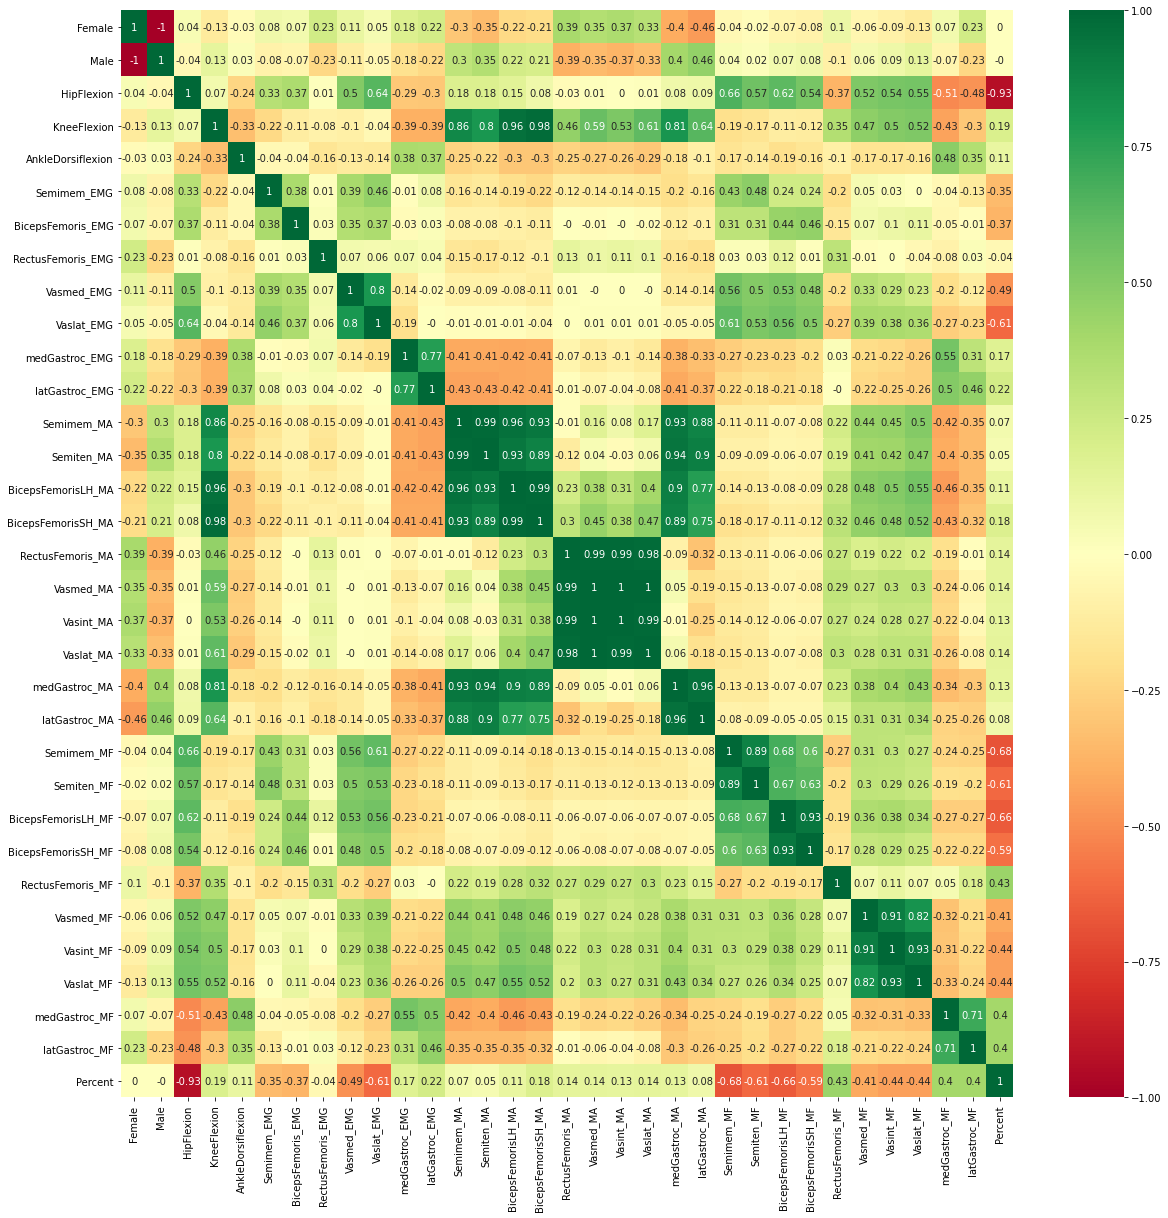

In [ ]:
# Plot the correlation matrix across all features as a heatmap. Only looking at training data
x = pd.DataFrame(X_train, columns = features)
x.head()
corrmat = x.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
g=sns.heatmap(round(x[top_corr_features].corr(),2),annot=True,cmap="RdYlGn")

In [ ]:
# Correlation coefficient value to cut off at
cutoff = 0.95

# Iterate through correlation values (as displayed in heatmap above) and
# identify features with correlation coeff > cutoff
data_corr = x[top_corr_features].corr().values
feat = []
for ind1, elem1 in enumerate(data_corr):
  for ind2, elem2 in enumerate(elem1):
    if elem2 > cutoff and ind1!=ind2:
      feat.append([features[ind1],features[ind2]])
feat = pd.DataFrame(feat, columns = ['Feature 1', 'Feature 2'])

# Remove duplicate combinations & display correlated features
res = feat[~feat[['Feature 1', 'Feature 2']].apply(frozenset, axis=1).duplicated()]
print(res)

             Feature 1           Feature 2
0          KneeFlexion  BicepsFemorisLH_MA
1          KneeFlexion  BicepsFemorisSH_MA
2           Semimem_MA          Semiten_MA
3           Semimem_MA  BicepsFemorisLH_MA
7   BicepsFemorisLH_MA  BicepsFemorisSH_MA
10    RectusFemoris_MA           Vasmed_MA
11    RectusFemoris_MA           Vasint_MA
12    RectusFemoris_MA           Vaslat_MA
14           Vasmed_MA           Vasint_MA
15           Vasmed_MA           Vaslat_MA
18           Vasint_MA           Vaslat_MA
22       medGastroc_MA       latGastroc_MA


In [ ]:
# Select features to remove from data. Currently selecting to remove features in
# first column (i.e. 'Feature 1)
rem = res['Feature 1']
rem = rem.drop_duplicates()
rem = np.array(rem)

print('Now removing {} features'.format(len(rem)))
X_train = pd.DataFrame(X_train, columns = features)
X_train = X_train.drop(columns = rem)
X_train = np.array(X_train)
X_test = pd.DataFrame(X_test, columns = features)
X_test = X_test.drop(columns = rem)
features = X_test.columns.values
X_test = np.array(X_test)

# New shape of model input data
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)

# New list of features
print('Features:', features )

Now removing 7 features
X_train shape:  (3400, 26)
X_test shape:  (800, 26)
Features: ['Female' 'Male' 'HipFlexion' 'AnkleDorsiflexion' 'Semimem_EMG'
 'BicepsFemoris_EMG' 'RectusFemoris_EMG' 'Vasmed_EMG' 'Vaslat_EMG'
 'medGastroc_EMG' 'latGastroc_EMG' 'Semiten_MA' 'BicepsFemorisSH_MA'
 'Vaslat_MA' 'latGastroc_MA' 'Semimem_MF' 'Semiten_MF'
 'BicepsFemorisLH_MF' 'BicepsFemorisSH_MF' 'RectusFemoris_MF' 'Vasmed_MF'
 'Vasint_MF' 'Vaslat_MF' 'medGastroc_MF' 'latGastroc_MF' 'Percent']


# Evaluate Feature Importances with Random Forests
In this section:
- Define a random forest classifier
- Fit training data to classifier and evaluate impurity-based feature importances (based on Gini impurity)
- Plot importances to visualize relative importance of features, informing feature selection
- Remove features of low importance (i.e. keep some specified number of most important features)

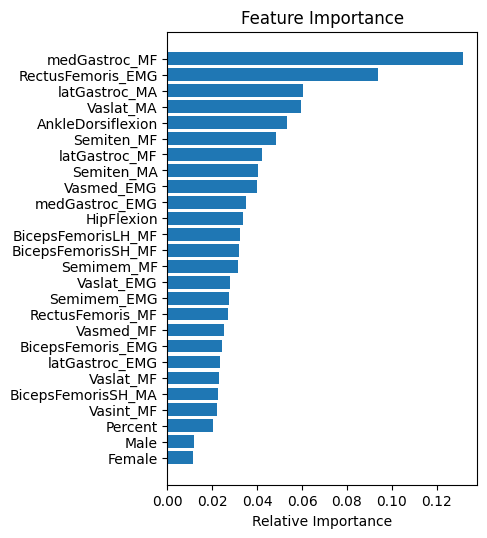

In [ ]:
# Define random forest model and fit with training data
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

# Generate impurity-based feature importances and order them from least to most 
# important.
importances = rfc.feature_importances_
sorted_idx = np.argsort(importances)

# Make a barplot to visualize relative importance of features
fig, ax = plt.subplots(figsize=(4,6),dpi=100)
padding = np.arange(len(features)) + 0.5
plt.barh(padding, importances[sorted_idx], align='center')
plt.yticks(padding, [features[i] for i in sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Feature Importance")
plt.show()

In [ ]:
# Number of top features to include
n = 26

imp_idx = sorted_idx[-n::]
new_features = [features[i] for i in imp_idx]

print('Now removing {} features'.format(len(sorted_idx)-n))
X_train = pd.DataFrame(X_train, columns = features)
X_train = X_train[new_features]
X_train = np.array(X_train)

X_test = pd.DataFrame(X_test, columns = features)
X_test = X_test[new_features]
X_test = np.array(X_test)

# New shape of model input data
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)

# New list of features
features = new_features
print('Features:', features )

Now removing 0 features
X_train shape:  (3400, 26)
X_test shape:  (800, 26)
Features: ['Female', 'Male', 'Percent', 'Vasint_MF', 'BicepsFemorisSH_MA', 'Vaslat_MF', 'latGastroc_EMG', 'BicepsFemoris_EMG', 'Vasmed_MF', 'RectusFemoris_MF', 'Semimem_EMG', 'Vaslat_EMG', 'Semimem_MF', 'BicepsFemorisSH_MF', 'BicepsFemorisLH_MF', 'HipFlexion', 'medGastroc_EMG', 'Vasmed_EMG', 'Semiten_MA', 'latGastroc_MF', 'Semiten_MF', 'AnkleDorsiflexion', 'Vaslat_MA', 'latGastroc_MA', 'RectusFemoris_EMG', 'medGastroc_MF']


# Logistic Regression Model

In this section:
- Define logistic regression classifier
- Parameter tuning
- K-fold cross validation
- Plot learning and validation curves
- Evaluate model on test dataset
- Plot confusion matrix

In [ ]:
# Parameter tuning via grid search
log_mod = LogisticRegression(solver='liblinear', random_state=0)
C = np.logspace(-4, 4, 20)
param_grid = {'C':C}

# Create grid search object
clf = GridSearchCV(log_mod, param_grid, cv = 10)

# Fit on data
best_clf = clf.fit(X_train, y_train[:,0])

# Display best parameter
print(clf.best_params_)

# Set best parameter to model
log_mod = log_mod.set_params(**clf.best_params_)

{'C': 0.08858667904100823}


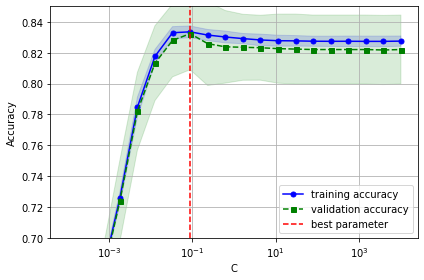

In [ ]:
# Plot the validation curve (see function defined at top of code)
param_name = 'C'
param_range = C
cv = 10
y_lim = [0.7, 0.85]
title = 'Logistic Regression'
val_curve(log_mod, X_train, y_train[:,0], param_name, C, cv, y_lim, title, clf.best_params_['C'])

In [ ]:
# K-fold cross validation
scores = cross_val_score(estimator=log_mod,
                         X=X_train,
                         y=y_train[:,0],
                         cv=10,
                         n_jobs=-1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.79411765 0.84705882 0.85294118 0.80882353 0.84411765 0.80882353
 0.87352941 0.81470588 0.84117647 0.83823529]
CV accuracy: 0.832 +/- 0.023


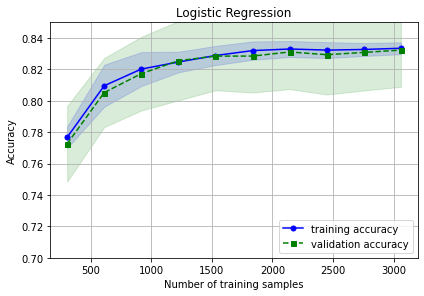

In [ ]:
# Plot the learning curve (see function defined at top of code)
train_sizes = np.linspace(0.1, 1.0, 10)
cv = 10
y_lim = [0, 1]
title = 'Logistic Regression'
learn_curve(log_mod, X_train, y_train[:,0], train_sizes, cv, y_lim, title)

In [ ]:
# Evaluate model
# Train the model using the training sets
log_mod.fit(X_train, y_train[:,0])

# Predict the response for test dataset
ypred = log_mod.predict(X_test)

# Display test accuracy
print('Test Accuracy: %.2f' % log_mod.score(X_test, y_test[:,0]))

Test Accuracy: 0.83


Text(0.5, 1.0, 'Logistic Regression')

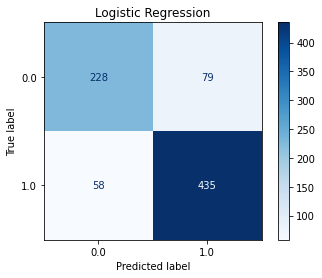

In [ ]:
# Confusion matrix
cnf_matrix = confusion_matrix(y_true=y_test[:,0], y_pred=ypred)

disp = plot_confusion_matrix(log_mod, X_test, y_test[:,0],
                                 cmap=plt.cm.Blues, values_format = '.0f'
                             )

title = 'Logistic Regression'
disp.ax_.set_title(title)

# Support Vector Machine
In this section:
- Define logistic regression classifier
- Parameter tuning
- K-fold cross validation
- Plot learning and validation curves
- Evaluate model on test dataset
- Plot confusion matrix

In [ ]:
# Parameter Tuning via Grid Search
svm_mod = SVC(kernel='linear', probability=True)
C = np.logspace(-3, 1,5)
gamma = np.logspace(-2, 1,4)
param_grid = {'C': C, 'gamma' : gamma}

# Create grid search object
clf = GridSearchCV(svm_mod, param_grid, cv = 10)

# Fit on data
best_clf = clf.fit(X_train, y_train[:,0])

# Display best parameter
print(clf.best_params_)

# Set best parameter to model
svm_mod = svm_mod.set_params(**clf.best_params_)

{'C': 0.1, 'gamma': 0.01}


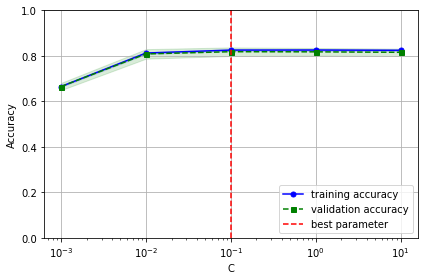

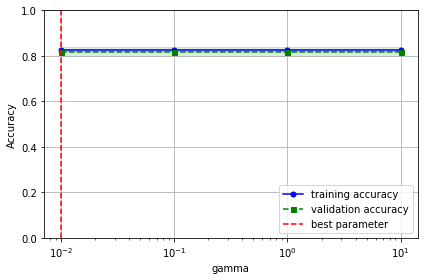

In [ ]:
# Plot the validation curves (see function defined at top of code)
# For Parameter C
param_name = 'C'
param_range = C
cv = 10
y_lim = [0, 1]
title = 'Support Vector Machine'
val_curve(svm_mod, X_train, y_train[:,0], param_name, C, cv, y_lim, title, clf.best_params_['C'])

# For Parameter gamma
param_name = 'gamma'
param_range = gamma
cv = 10
y_lim = [0, 1]
title = 'Support Vector Machine'
val_curve(svm_mod, X_train, y_train[:,0], param_name, gamma, cv, y_lim, title, clf.best_params_['gamma'])

In [ ]:
# K-fold cross validation
scores = cross_val_score(estimator=svm_mod,
                         X=X_train,
                         y=y_train[:,0],
                         cv=10,
                         n_jobs=-1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.81176471 0.82941176 0.82647059 0.84705882 0.81764706 0.77647059
 0.79705882 0.83529412 0.82058824 0.82352941]
CV accuracy: 0.819 +/- 0.019


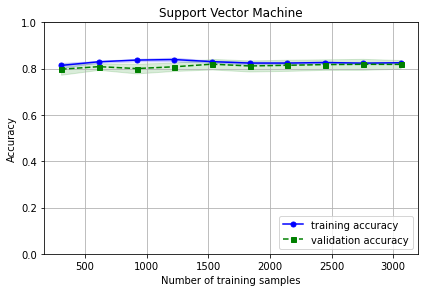

In [ ]:
# Plot the learning curve (see function defined at top of code)
train_sizes = np.linspace(0.1, 1.0, 10)
cv = 10
y_lim = [0, 1]
title = 'Support Vector Machine'
learn_curve(svm_mod, X_train, y_train[:,0], train_sizes, cv, y_lim, title)

In [ ]:
# Evaluate model
# Train the model using the training sets
svm_mod.fit(X_train, y_train[:,0])

# Predict the response for test dataset
ypred = svm_mod.predict(X_test)

# Display test accuracy
print('Test Accuracy: %.2f' % svm_mod.score(X_test, y_test[:,0]))

Test Accuracy: 0.84


Text(0.5, 1.0, 'Support Vector Machine')

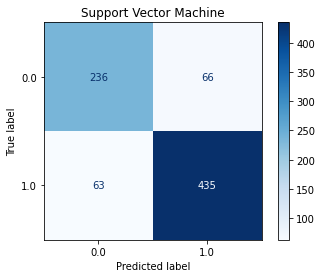

In [ ]:
# Confusion matrix
cnf_matrix = confusion_matrix(y_true=y_test[:,0], y_pred=ypred)

disp = plot_confusion_matrix(svm_mod, X_test, y_test[:,0],
                                 cmap=plt.cm.Blues, values_format = '.0f'
                             )

title = 'Support Vector Machine'
disp.ax_.set_title(title)

# Random Forest Model

In this section:
- Define Random Forest classifier
- Parameter tuning
- K-fold cross validation
- Plot learning and validation curves
- Evaluate model on test dataset
- Plot confusion matrix


In [ ]:
# Parameter Tuning via Grid Search
RF_mod = RandomForestClassifier()
       
max_depth = (2, 3, 4)
bootstrap = (False, True)
max_features = ('auto', 'sqrt', 'log2', None)
criterion = ('gini', 'entropy')


param_grid = {'max_depth': max_depth, 'bootstrap' : bootstrap , 'max_features' : max_features,  
              'criterion' : criterion}

# Create grid search object
clf = GridSearchCV(RF_mod, param_grid, cv = 10)

# Fit on data
best_clf = clf.fit(X_train, y_train[:,0])

# Display best parameter
print(clf.best_params_)

# Set best parameter to model
RF_mod = RF_mod.set_params(**clf.best_params_)

{'bootstrap': True, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto'}


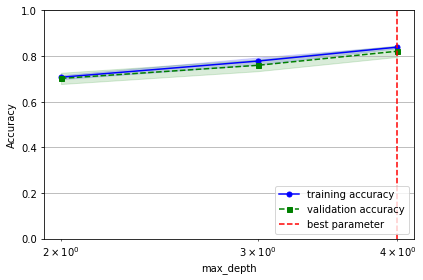

In [ ]:
# Plot the validation curves (see function defined at top of code)
# For maximum depth
param_name = 'max_depth'
param_range = max_depth
cv = 10
y_lim = [0, 1]
title = 'Random Forest'
val_curve(RF_mod, X_train, y_train[:,0], param_name, max_depth, cv, y_lim, title, clf.best_params_['max_depth'])

In [ ]:
#K-fold cross validation
scores = cross_val_score(estimator=RF_mod,
                         X=X_train,
                         y=y_train[:,0],
                         cv=10,
                         n_jobs=-1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.82352941 0.82647059 0.84411765 0.81176471 0.84705882 0.79117647
 0.78235294 0.81764706 0.84705882 0.83823529]
CV accuracy: 0.823 +/- 0.022


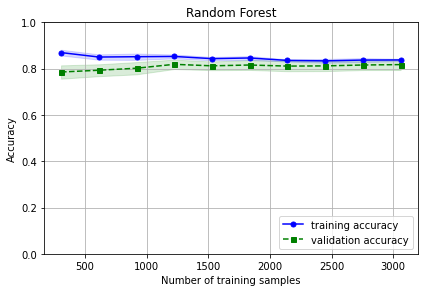

In [ ]:
# Plot the learning curve (see function defined at top of code)
train_sizes = np.linspace(0.1, 1.0, 10)
cv = 10
y_lim = [0, 1]
title = 'Random Forest'
learn_curve(RF_mod, X_train, y_train[:,0], train_sizes, cv, y_lim, title)

In [ ]:
# Evaluate model
# Train the model using the training sets
RF_mod.fit(X_train, y_train[:,0])

# Predict the response for test dataset
ypred = RF_mod.predict(X_test)

# Display test accuracy
print('Test Accuracy: %.2f' % RF_mod.score(X_test, y_test[:,0]))

Test Accuracy: 0.85


Text(0.5, 1.0, 'Random Forest')

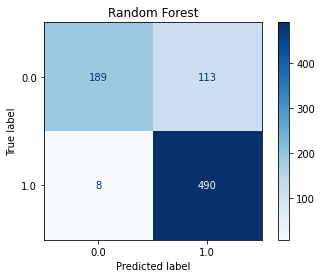

In [ ]:
# Confusion matrix
cnf_matrix = confusion_matrix(y_true=y_test[:,0], y_pred=ypred)

disp = plot_confusion_matrix(RF_mod, X_test, y_test[:,0],
                                 cmap=plt.cm.Blues, values_format = '.0f'
                             )

title = 'Random Forest'
disp.ax_.set_title(title)

# Model Evaluations: ROC

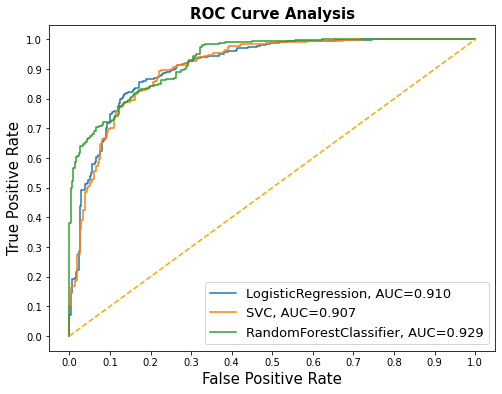

In [ ]:
# Make a list of classifiers
classifiers = [log_mod, 
               svm_mod,
               RF_mod]

# Make Dataframe of results
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train and record results
for cls in classifiers:
    model = cls.fit(X_train, y_train[:,0])
    yprob = model.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test[:,0],  yprob)
    auc = roc_auc_score(y_test[:,0], yprob)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()